In [1]:
# !pip install tensorflow==2.15.0
# !pip install tf_keras==2.15.0

In [2]:
# Use legacy Keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [3]:
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs

from src.tower import Tower
from src.embedding import Embedding
from src.recommender import RecommenderModel
from src.utils.utilities import (
    parquet_to_Dataset,
    train_test_split,
    plot_history,
)

RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)

2024-09-02 09:16:57.478102: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-02 09:16:57.482887: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-02 09:16:57.495712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-02 09:16:57.518184: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-02 09:16:57.524675: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-02 09:16:57.544709: I tensorflow/core/platform/cpu_feature_gu

In [4]:
# Load ratings dataset
ratings_dataset = parquet_to_Dataset(
    path = 'data/100k-ratings.parquet',
    exclude_columns = ['movie_genres']
)

# Load movies dataset
movies_dataset = parquet_to_Dataset(
    path = 'data/100k-movies.parquet',
    exclude_columns = ['movie_genres']
)

I0000 00:00:1725256021.658594   26342 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-02 09:17:01.659215: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Dataset Splitting

In [5]:
# Split ratings dataset into train and validation
ratings_trainset, ratings_validset = train_test_split(
    dataset = ratings_dataset,
    train_size = 0.8,
    random_state = RANDOM_STATE,
    buffer_size = 10_000
)

print(f"trainset_size:", ratings_trainset.__len__().numpy())
print(f"validset_size:", ratings_validset.__len__().numpy())

trainset_size: 80000
validset_size: 20000


In [6]:
# Create user embedding
user_embedding_model = Embedding(
    dataset = ratings_dataset.batch(1_000_000),
    str_features = ['user_id', 'user_zip_code', 'user_occupation_text'],
    int_features = ['user_gender', 'bucketized_user_age'],
    text_features = [],
    timestamp_features = ['timestamp'],
    embedding_dim = 32,
)

# Create movie embedding
movie_embedding_model = Embedding(
    dataset = movies_dataset.batch(1_000),
    str_features = [],
    int_features = [],
    text_features = ['movie_title'],
    timestamp_features = [],
    embedding_dim = 32,
)

2024-09-02 09:17:02.909181: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-02 09:17:04.097566: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-09-02 09:17:06.488911: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
cross_layer = tfrs.layers.dcn.Cross(
    projection_dim = 32,
    kernel_initializer = "glorot_uniform"
)

candidate_tower = Tower(
    embedding_model = movie_embedding_model,
    cross_layer = cross_layer,
    dense_layers = [32]
)

query_tower = Tower(
    embedding_model = user_embedding_model,
    cross_layer = cross_layer,
    dense_layers = [32]
)

factorized_top_k_metrics = tfrs.metrics.FactorizedTopK(
    candidates = movies_dataset.batch(128).map(candidate_tower)
)

In [8]:
# Ranking
ranking_task = tfrs.tasks.Ranking(
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [
        tf.keras.metrics.RootMeanSquaredError(),
    ]
)

# Retrieval
retrieval_task = tfrs.tasks.Retrieval(
    metrics = [
        factorized_top_k_metrics
    ]
)

model = RecommenderModel(
    query_tower = query_tower,
    candidate_tower = candidate_tower,
    ranking_task = ranking_task,
    retrieval_task = retrieval_task,
    retrieval_weight = 0.2,
    ranking_weight = 0.8,
)

optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1)
model.compile(optimizer = optimizer)

In [9]:
cached_ratings_trainset = ratings_trainset.shuffle(100_000).batch(1024).cache()
cached_ratings_validset = ratings_validset.batch(1024).cache()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'total_loss',
    patience = 10,
)

history = model.fit(
    cached_ratings_trainset,
    validation_data = cached_ratings_validset,
    validation_freq = 1,
    epochs = 10,
    callbacks = [
        early_stopping_callback
    ]
)

Epoch 1/10
79/79 [==============================] - 11s 92ms/step - root_mean_squared_error: 0.0000e+00 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 1354.2468 - regularization_loss: 0.0000e+00 - total_loss: 1354.2468 - val_root_mean_squared_error: 1.1191 - val_factorized_top_k/top_1_categorical_accuracy: 0.0014 - val_factorized_top_k/top_5_categorical_accuracy: 0.0100 - val_factorized_top_k/top_10_categorical_accuracy: 0.0206 - val_factorized_top_k/top_50_categorical_accuracy: 0.0990 - val_factorized_top_k/top_100_categorical_accuracy: 0.1977 - val_loss: 644.8259 - val_regularization_loss: 0.0000e+00 - val_total_loss: 644.8259
Epoch 2/10
79/79 [==============================] - 4s 55ms/step - root_mean_squared_error: 0.0000e+00 - fac

In [10]:
model.evaluate(cached_ratings_validset, return_dict=True)

20/20 [==============================] - 3s 141ms/step - root_mean_squared_error: 1.0090 - factorized_top_k/top_1_categorical_accuracy: 6.5000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0076 - factorized_top_k/top_10_categorical_accuracy: 0.0189 - factorized_top_k/top_50_categorical_accuracy: 0.1288 - factorized_top_k/top_100_categorical_accuracy: 0.2634 - loss: 1256.3831 - regularization_loss: 0.0000e+00 - total_loss: 1256.3831


{'root_mean_squared_error': 1.0089770555496216,
 'factorized_top_k/top_1_categorical_accuracy': 0.0006500000017695129,
 'factorized_top_k/top_5_categorical_accuracy': 0.007550000213086605,
 'factorized_top_k/top_10_categorical_accuracy': 0.018850000575184822,
 'factorized_top_k/top_50_categorical_accuracy': 0.12880000472068787,
 'factorized_top_k/top_100_categorical_accuracy': 0.2634499967098236,
 'loss': 622.8229370117188,
 'regularization_loss': 0,
 'total_loss': 622.8229370117188}

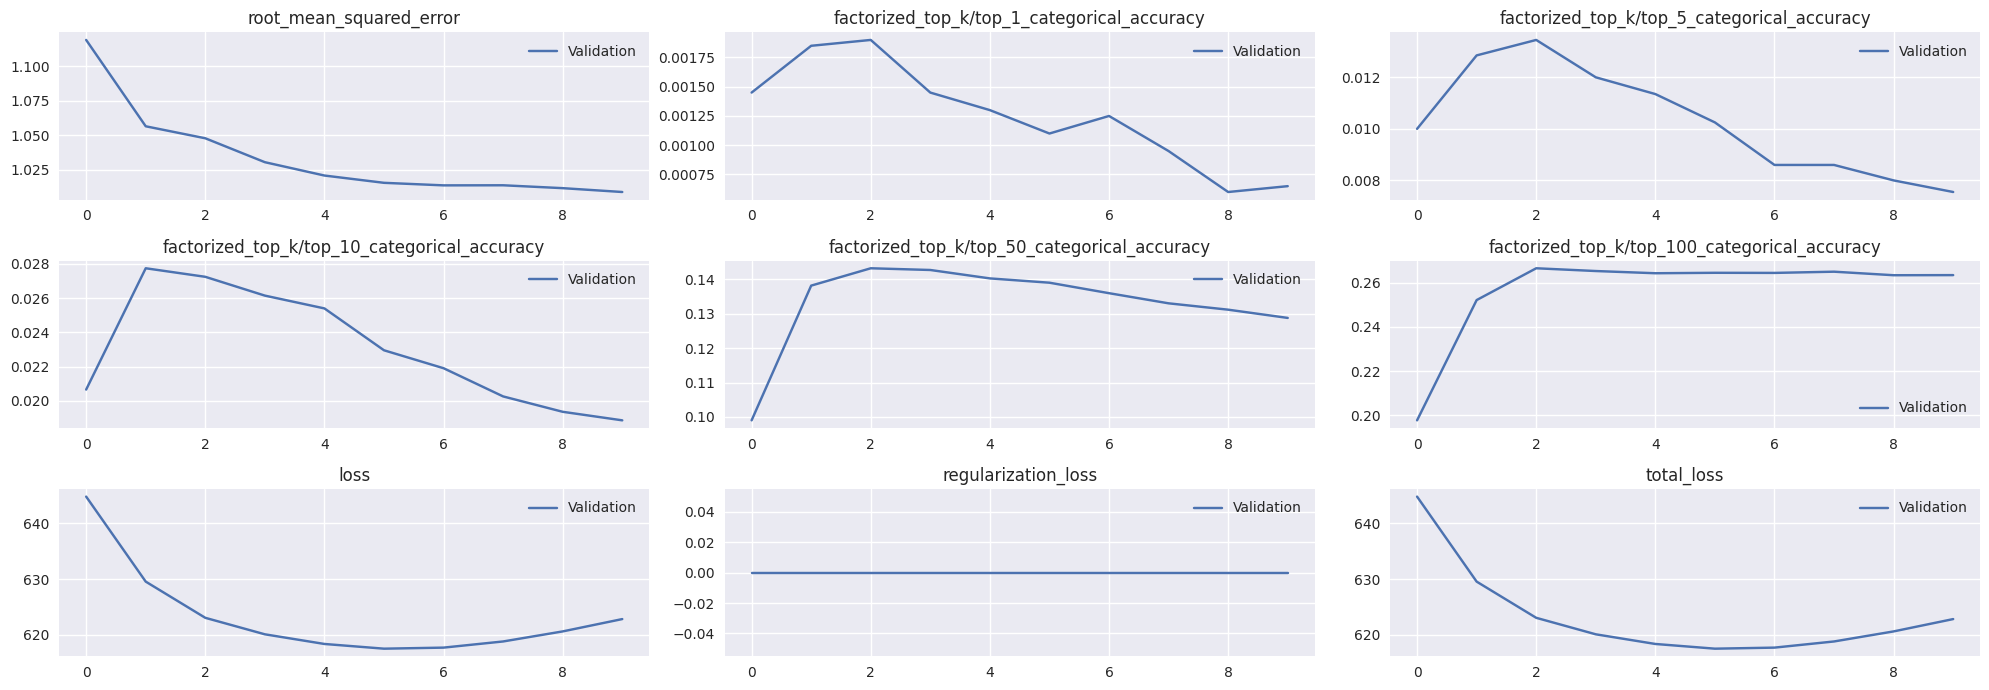

In [11]:
plot_history(history = history, plot_training=False)

In [12]:
scann_layer = tfrs.layers.factorized_top_k.ScaNN(
    model.query_tower,
    k = 10,
)

scann_layer.index_from_dataset(
  tf.data.Dataset.zip(
      (
          movies_dataset.map(lambda movie: movie['movie_id']).batch(100),
          movies_dataset.batch(100).map(model.candidate_tower)
      )
  )
)

2024-09-02 09:18:05.234226: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 1682
2024-09-02 09:18:05.235775: W scann/utils/gmm_utils.cc:920] Could not normalize centroid due to zero norm or empty or zero-weight partition.
2024-09-02 09:18:05.239954: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:89] PartitionerFactory ran in 5.62142ms.


In [19]:
index = 0
data = ratings_dataset.take(1).as_numpy_iterator().next()
data = {k: tf.convert_to_tensor([v]) for k, v in data.items()}

afinity_scores, movie_ids = scann_layer(data)

for movie_id in movie_ids[0]:

    pred = model(data)
    _, _, rating = pred

    print(f"Movie {movie_id}: {rating[0][0]}")

Movie b'847': 4.077889919281006
Movie b'604': 4.077889919281006
Movie b'478': 4.077889919281006
Movie b'14': 4.077889919281006
Movie b'483': 4.077889919281006
Movie b'137': 4.077889919281006
Movie b'513': 4.077889919281006
Movie b'487': 4.077889919281006
Movie b'503': 4.077889919281006
Movie b'1450': 4.077889919281006
